In [ ]:
%%capture
!pip install --upgrade pip && pip install ccxt stockstats

In [ ]:
# 3rd party modules
import numpy as np
import pandas as pd
import ccxt
from ccxt import Exchange
from google.colab import userdata
from stockstats import StockDataFrame

In [ ]:
# Secrets
EXCHANGE_API_KEY: str = userdata.get("EXCHANGE_API_KEY")
EXCHANGE_SECRET: str = userdata.get("EXCHANGE_SECRET")
EXCHANGE_PASSWORD: str = userdata.get("EXCHANGE_PASSWORD")

# Set parameters for calculation
EXCHANGE_NAME: str = "kucoin"
SYMBOL: str = "XMR/USDT"
BASE: str = SYMBOL.split('/')[0]
QUOTE: str = SYMBOL.split('/')[1]
TIMEFRAME: str = "5m"

# Number of 'TIMEFRAME' intervals
DATA_VECTOR_LENGTH: int = 1000

# Exchange fee & minimum deal value
TRANSACTION_FEE: float = 0.001
MIN_QUOTE_VALUE: float = 0.01

# Norm of profit
PRICE_PREMIUM_OR_DISCOUNT_OVER_FEE: float = 0.001
PREM_DISC: float = TRANSACTION_FEE + PRICE_PREMIUM_OR_DISCOUNT_OVER_FEE

In [ ]:
pd.options.mode.copy_on_write = True

In [ ]:
exchange: Exchange = getattr(ccxt, EXCHANGE_NAME)()

In [ ]:
data = exchange.fetch_ohlcv(
                    SYMBOL, TIMEFRAME, limit=DATA_VECTOR_LENGTH)

In [ ]:
# case is important (StockDataFrame looks for 'date' to index data)
header: tuple = ('date', 'open', 'high', 'low', 'close', 'volume')
df = pd.DataFrame(data, columns=header)

In [ ]:
# Process as stocks data
sdf = StockDataFrame.retype(df)

# Set indicator (& all underlying ind-s) window size to `win_size` periods
wait_for_n_signal_lags: int = 1
indicators: list[str] = ['close_5,15_kama']


# Price data (or other trend)
price_type_column_name_from_sdf: str = 'close_3_ema'

# Price to simulate orders with
price: str = "middle"

In [ ]:
out: pd.DataFrame = sdf[[*indicators, price_type_column_name_from_sdf, price]]

In [ ]:
_x = [sdf[f'{price_type_column_name_from_sdf}_xu_{indicator}{"_delta" * wait_for_n_signal_lags}'] *
      sdf[indicator].le(sdf[price_type_column_name_from_sdf])
      for indicator in indicators]

_a = [sdf[f'{price_type_column_name_from_sdf}_xd_{indicator}{"_delta" * wait_for_n_signal_lags}'] *
      sdf[price_type_column_name_from_sdf].le(sdf[indicator])
      for indicator in indicators]

if wait_for_n_signal_lags > 1:
    _x += [-sdf[f'{price_type_column_name_from_sdf}_xd_{indicator}{"_delta" * i}']
          for i in range(1, wait_for_n_signal_lags)
          for indicator in indicators]
    _a += [-sdf[f'{price_type_column_name_from_sdf}_xu_{indicator}{"_delta" * i}']
          for i in range(1, wait_for_n_signal_lags)
          for indicator in indicators]

out['signal_buy'] = np.logical_and.reduce(_x)
out['signal_sell'] = np.logical_and.reduce(_a)

In [ ]:
sum(out['signal_buy'] == True)

116

In [ ]:
alls = out['signal_buy'][out['signal_buy'] == True] & out['signal_buy'][out['signal_buy'] == True]
assert alls.all(), "NUMPY YIELDS UNEXPLAINED RESULTS FOR MULTIPLICATION"

In [ ]:
def intersects(df):
    col1 = 'signal_buy'
    col2 = 'signal_sell'
    condition = df[col1] == True
    return df[col1][condition] & df[col2][condition]

In [ ]:
_i = intersects(out)
print(_i.shape)
if _i.any():
    out.loc[_i[_i == True].index, "signal_buy"] = False
    out.loc[_i[_i == True].index, "signal_sell"] = False

(116,)


In [ ]:
# Just checking expected behavior (MUST BE FALSE), if all good – nothing happens
assert not intersects(out).any(), "CHECK FAILED"

In [ ]:
def up_or_down_from_last(df: pd.DataFrame) -> str:
    """

        :param df: a df with signals that has either a 'signal_buy' column or a 'sinal_sell' column.
        :return: str instance of 'up' or 'down', or 'error (if df doesn't have specified columns).
    """
    assert isinstance(df, pd.DataFrame) or issubclass(type(df), pd.DataFrame), "NOT A DATAFRAME OBJECT"
    assert "signal_buy" in df.columns and 'signal_sell' in df.columns, "NO COLUMNS"


    signal_buy: bool = df["signal_buy"].tail(1).item()
    signal_sell: bool = df["signal_sell"].tail(1).item()

    if signal_buy:
        return "up"

    if signal_sell:
        return "down"

    return "hold"


In [ ]:
# Good method
signals = [up_or_down_from_last(out.head(i)) for i in range(1, len(out))]


# Data lag
diff = len(out[price_type_column_name_from_sdf]) - len(signals)

In [ ]:
budget_quote: float = 8.09
budget_base: float = 0.0
budget_base_in_quote: float = budget_base * out[price_type_column_name_from_sdf].head(1).item()
trust: float = 0.85 # universal distrust is 0.5
risk_free_percentage_annual: float = 5.0

# Must be updated accordingly every time TIMEFRAME is changed
risk_free_percentage: float = risk_free_percentage_annual / 360 / 24 / 60 * 5 * DATA_VECTOR_LENGTH # Not annual rate!!!

In [ ]:
def simulate(
        trust: float,
        budget: float | int,
        base_position: float | int,
        quote_position: float | int,
        predictions: list,
        prices: list,
        epochs: int = 10,
    ) -> tuple[float | None, float | None]:


    if len(predictions) <= epochs:
        current_base: float = base_position
        current_quote: float = quote_position

        for e in range(epochs):


            if predictions[e] == "up":
                price: float = prices[e] * (1 - PREM_DISC)
                deal_value_base: float = trust * current_quote / price
                deal_value_quote: float = price * deal_value_base

                if deal_value_quote > MIN_QUOTE_VALUE:
                    # print(f'Bullish, {BASE}{round(deal_value_base, 4)} for {QUOTE}{round(deal_value_quote, 2)};{current_base, current_quote}')

                    current_quote -= deal_value_quote
                    current_base += deal_value_base
                else:
                    continue

            elif predictions[e] == "down":
                price: float = prices[e] * (1 + PREM_DISC)
                deal_value_quote: float = trust * current_base * price
                deal_value_base: float = deal_value_quote / price

                if deal_value_quote > MIN_QUOTE_VALUE:
                    # print(f'Bearish, {BASE}{round(deal_value_base, 4)} for {QUOTE}{round(deal_value_quote, 2)};{current_base, current_quote}')

                    current_quote += deal_value_quote
                    current_base -= deal_value_base

                else:
                    continue

            else:
                continue

        return current_base, current_quote


    return None, None

In [ ]:
new_base, new_quote = simulate(
    trust=trust,
    budget=budget_quote,
    base_position=budget_base,
    quote_position=budget_quote,
    predictions=signals,
    prices=list(out[price][diff:]),
    epochs=len(signals)
)

# Simulation result

In [ ]:
base_total_in_quote: float = new_base * out[price_type_column_name_from_sdf].tail(1).item()
result: float = round(100 * (base_total_in_quote + new_quote) / (budget_quote + budget_base_in_quote) - 100, 4)
print(f"Result: {result}% ({'OKAY' if result > 0 else 'NOT OKAY'})")
over_risk_free: float = round(result - risk_free_percentage, 4)
print(f"Result over benchmark: {over_risk_free}% ({'BAD' if over_risk_free < 0 else 'GOOD'})")

Result: 21.8272% (OKAY)
Result over benchmark: 21.779% (GOOD)


In [ ]:
base_total_in_quote + new_quote

9.855822487718514

<Axes: xlabel='date'>

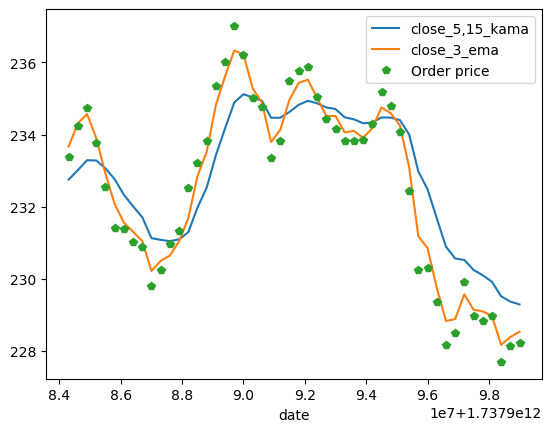

In [ ]:
N: int = 50
for indicator in indicators:
    sdf[indicator].tail(N).plot(legend=True)
sdf[price_type_column_name_from_sdf].tail(N).plot(legend=True)
sdf[price].tail(N).plot(style="p", legend=True, label="Order price")